### Chapter -3: ML Implementation: 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

!pip install xgboost

In [2]:
df = pd.read_csv('../data/nyc_data/final_dataset.csv', compression='gzip')
df.head()

,line_name,org_name,dest_name,vech_name,weekend_status,day_of_year,month_number,day_of_month,time_of_day,delays
0,B46-SBS,UTICA AV/AV N,SELECT BUS De KALB AV via UTICA,NYCT_7330,False,156,6,5,439,1.85
1,M101,LEXINGTON AV/E 100 ST,LTD EAST VILLAGE 6 ST via LEX AV,NYCT_6057,False,342,12,8,721,10.03
2,Bx31,TREMONT AV/LANE AV,WOODLAWN KATONAH AV,NYCT_7703,False,298,10,25,341,0.10
3,Q20A,COLLEGE PT BL/15 AV,JAMAICA MERRICK BL via 20 AV via MAIN S,NYCT_7391,False,278,10,5,825,0.15
4,Bx34,VALENTINE AV/E FORDHAM RD,WOODLAWN KATONAH AV,NYCT_4102,False,347,12,13,439,0.23


In [3]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (1000000, 10)


In [4]:
# Line name mapping

df.insert (df.columns.get_loc('line_name')+1, 'line_number', pd.factorize(df['line_name'])[0])
df.insert (df.columns.get_loc('org_name')+1, 'org_number', pd.factorize(df['org_name'])[0])
df.insert (df.columns.get_loc('dest_name')+1, 'dest_number', pd.factorize(df['dest_name'])[0])
df.insert (df.columns.get_loc('vech_name')+1, 'vech_number', pd.factorize(df['vech_name'])[0])
df.insert (df.columns.get_loc('weekend_status')+1, 'is_weekend', pd.factorize(df['weekend_status'])[0])

df.head()

,line_name,line_number,org_name,org_number,dest_name,dest_number,vech_name,vech_number,weekend_status,is_weekend,day_of_year,month_number,day_of_month,time_of_day,delays
0,B46-SBS,0,UTICA AV/AV N,0,SELECT BUS De KALB AV via UTICA,0,NYCT_7330,0,False,0,156,6,5,439,1.85
1,M101,1,LEXINGTON AV/E 100 ST,1,LTD EAST VILLAGE 6 ST via LEX AV,1,NYCT_6057,1,False,0,342,12,8,721,10.03
2,Bx31,2,TREMONT AV/LANE AV,2,WOODLAWN KATONAH AV,2,NYCT_7703,2,False,0,298,10,25,341,0.10
3,Q20A,3,COLLEGE PT BL/15 AV,3,JAMAICA MERRICK BL via 20 AV via MAIN S,3,NYCT_7391,3,False,0,278,10,5,825,0.15
4,Bx34,4,VALENTINE AV/E FORDHAM RD,4,WOODLAWN KATONAH AV,2,NYCT_4102,4,False,0,347,12,13,439,0.23


df.drop('line_number', axis=1, inplace=True) <br>
df.head()

In [5]:
df_final = df[['line_number', 'org_number', 'dest_number', 'vech_number', 'is_weekend', 
               'day_of_year', 'month_number', 'day_of_month', 'time_of_day', 'delays']]

df_final.head()

,line_number,org_number,dest_number,vech_number,is_weekend,day_of_year,month_number,day_of_month,time_of_day,delays
0,0,0,0,0,0,156,6,5,439,1.85
1,1,1,1,1,0,342,12,8,721,10.03
2,2,2,2,2,0,298,10,25,341,0.10
3,3,3,3,3,0,278,10,5,825,0.15
4,4,4,2,4,0,347,12,13,439,0.23


In [6]:
df_final.tail()

,line_number,org_number,dest_number,vech_number,is_weekend,day_of_year,month_number,day_of_month,time_of_day,delays
999995,71,499,190,1149,0,304,10,31,900,7.40
999996,178,247,279,4139,0,362,12,28,1031,9.58
999997,86,394,138,4452,0,286,10,13,462,7.08
999998,213,232,465,1048,0,153,6,2,445,0.48
999999,61,234,311,2239,0,171,6,20,1387,0.00


In [7]:
# dataframe to numpy array
np_data = df_final.to_numpy()

In [8]:
# Shape of the array
np_data.shape

(1000000, 10)

In [10]:
# Independent variables
X = np_data[:, 0:np_data.shape[1]-1]
X.shape

(1000000, 9)

In [11]:
# Labeled data
y = np_data[:, np_data.shape[1]-1]
y.shape

(1000000,)

In [12]:
# Train-Test split...
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
print(f'X Train {x_train.shape}, X Test: {x_test.shape}, Y train: {y_train.shape}, Y Test: {y_test.shape}')

X Train (800000, 9), X Test: (200000, 9), Y train: (800000,), Y Test: (200000,)


In [13]:
# Plot actual vs predicted values

def plot_outcomes(actual, predicted, fig):
    indices = list(range(actual.shape[0]))
    f = plt.figure()
    f.set_figwidth(14)
    f.set_figheight(8)

   
    plt.plot(indices, actual, label = "Actual")
    plt.plot(indices, predicted, label = "Predicted")
    plt.legend()
    
    plt.savefig(f'../Documentation/Figure/{fig}.png',  bbox_inches='tight')
    
    return plt

Coefficients: [-4.95098058e-03 -2.40001629e-03  8.87056957e-04  4.83572921e-05
  3.98040717e-01 -3.26490386e+00  9.95879609e+01  3.24205572e+00
  3.29442801e-03]

Mean squared error: 8.894963577608513
Coefficient of determination: 0.017925941050149108


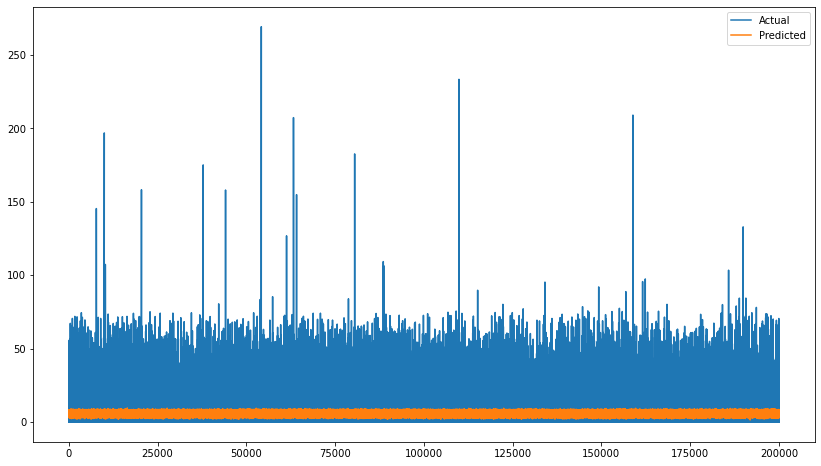

In [14]:
# Apply linear regression

clf = LinearRegression().fit(x_train, y_train)
y_predict = clf.predict(x_test)

print(f'Coefficients: {clf.coef_}')
print(f'\nMean squared error: {math.sqrt(mean_squared_error(y_test, y_predict))}')
print(f'Coefficient of determination: {r2_score(y_test, y_predict)}')

plot_outcomes(y_test, y_predict, '11').show()

In [15]:
# Apply Xboost regression
clf_xgb = xgb.XGBRegressor()
clf_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Root Mean squared error: 8.35


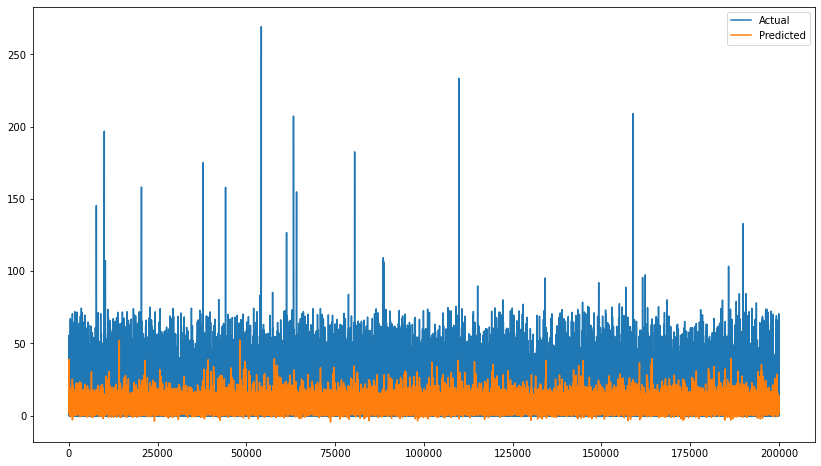

In [16]:
# predict outcome
y_predict = clf_xgb.predict(x_test)
print(f'Root Mean squared error: {round(math.sqrt(mean_squared_error(y_test, y_predict)), 2)}')

plot_outcomes(y_test, y_predict, '12').show()

In [17]:
# Hyper parameter optimizations

n_estimators = [100, 500, 900, 1200]
max_depth = [2, 3, 5, 10]
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.20]
min_child_weight = [1, 2, 4]
base_score = [0.25, 0.5, 0.75, 1]

heyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'min_child_weight':min_child_weight,
    'booster': booster,
    'base_score':base_score
}

In [18]:
# Initialize randomize search 
random_cv = RandomizedSearchCV(estimator=clf_xgb,
                              param_distributions=heyperparameter_grid,
                              cv = 5,
                              n_iter=50,
                              scoring='neg_mean_absolute_error',
                              n_jobs=4,
                              verbose=5,
                              return_train_score=True,
                              random_state=42)

In [19]:
#fit randomize search object
random_cv.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 4/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=1200;, score=(train=-5.552, test=-5.539) total time= 2.9min
[CV 3/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.490, test=-5.527) total time=  39.4s
[19:09:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 1/5] END base_score=0.25, booster=gblinear, learning_rate=0.15, max_depth=5, min_child_weig

[19:21:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 5/5] END base_score=0.25, booster=gblinear, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=1200;, score=(train=-5.808, test=-5.778) total time=  38.6s
[19:22:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_

/Users/zeotaplaptop/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=1200;, score=(train=-5.543, test=-5.568) total time= 2.9min
[CV 2/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.482, test=-5.534) total time=  38.7s
[CV 4/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.494, test=-5.489) total time=  38.5s
[19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } ar

[CV 5/5] END base_score=0.75, booster=gbtree, learning_rate=0.15, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.461, test=-5.448) total time=  39.4s
[CV 2/5] END base_score=0.5, booster=gbtree, learning_rate=0.2, max_depth=10, min_child_weight=4, n_estimators=1200;, score=(train=-3.015, test=-5.358) total time=18.5min
[20:22:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 1/5] END base_score=0.5, booster=gblinear, learning_rate=0.05, max_depth=2, min_child_weight=4, n_estimators=500;, score=(train=-5.793, test=-5.781) t

[CV 1/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=1200;, score=(train=-5.552, test=-5.540) total time= 2.9min
[CV 1/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.496, test=-5.492) total time=  39.5s
[CV 5/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.501, test=-5.480) total time=  38.6s
[19:10:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } ar

[20:34:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 2/5] END base_score=0.5, booster=gblinear, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=500;, score=(train=-5.784, test=-5.822) total time=  17.3s
[20:34:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_d

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.3000...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, ...),
    

[CV 4/5] END base_score=1, booster=gbtree, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=900;, score=(train=-4.589, test=-5.212) total time=13.9min
[CV 5/5] END base_score=0.5, booster=gbtree, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=500;, score=(train=-5.444, test=-5.426) total time= 2.1min
[20:59:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 4/5] END base_score=0.25, booster=gblinear, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=900;, score=(train=-5.803, test=-5.786) tota

[20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 3/5] END base_score=0.5, booster=gblinear, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=500;, score=(train=-5.785, test=-5.805) total time=  17.3s
[20:33:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_

[20:53:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[CV 1/5] END base_score=0.75, booster=gblinear, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=100;, score=(train=-5.793, test=-5.782) total time=   3.5s
[20:53:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_

In [20]:
# best parameters
print(f'The Best parameters are: {random_cv.best_estimator_}')

The Best parameters are: XGBRegressor(base_score=1, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


#### The Best parameters are: 
(base_score=1, booster='gbtree', callbacks=None,
colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
early_stopping_rounds=None, enable_categorical=False,
eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
grow_policy='depthwise', importance_type=None,
interaction_constraints='', learning_rate=0.05, max_bin=256,
max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
max_depth=10, max_leaves=0, min_child_weight=4, missing=nan,
monotone_constraints='()', n_estimators=900, n_jobs=0,
num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [22]:
# train with best parameters
clf_xgb_best = xgb.XGBRegressor(base_score=1, booster='gbtree', callbacks=None, colsample_bylevel=1, 
                                colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None, 
                                enable_categorical=False, eval_metric=None, feature_types=None, gamma=0,
                                gpu_id=-1, grow_policy='depthwise', importance_type=None, 
                                interaction_constraints='', learning_rate=0.05, max_bin=256, max_cat_threshold=64, 
                                max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=4,
                                missing=np.nan, monotone_constraints='()', n_estimators=900, n_jobs=0, 
                                num_parallel_tree=1, predictor='auto', random_state=0)

clf_xgb_best.fit(x_train, y_train)

XGBRegressor(base_score=1, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Root Mean squared error: 8.09


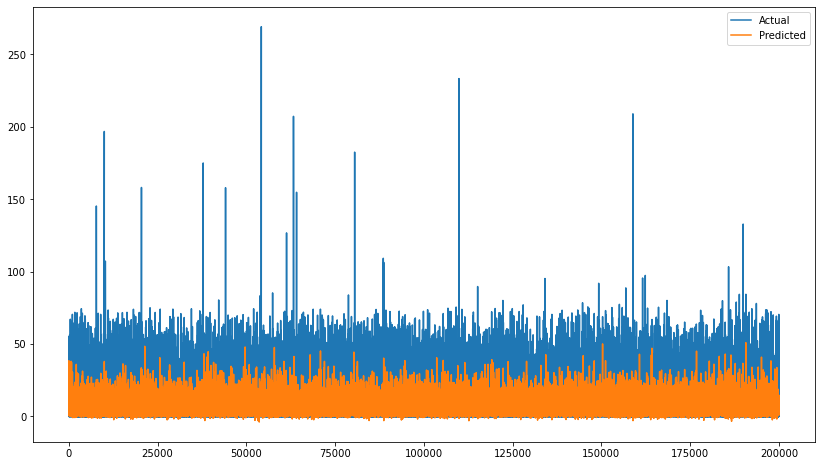

In [24]:
# predict outcome
y_predict = clf_xgb_best.predict(x_test)
print(f'Root Mean squared error: {round(math.sqrt(mean_squared_error(y_test, y_predict)), 2)}')

plot_outcomes(y_test, y_predict, '13').show()